In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

## 0. Import DarkHistory and DM21cm (this) package
(Sec environment variable `$DH_DIR` to directory containing `main.py`. subMIT requires special treatment.)

In [2]:
# darkhistory
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    os.environ['DH_DIR'] = '/work/submit/yitians/darkhistory/DarkHistory'
    os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/DM21cm'
sys.path.append(os.environ['DH_DIR'])
# DM21cm
sys.path.append('..')

## 1. Define a Spectrum

In [3]:
from darkhistory.spec.spectrum import Spectrum

from dm21cm.common import abscs_nBs_test
abscs = abscs_nBs_test

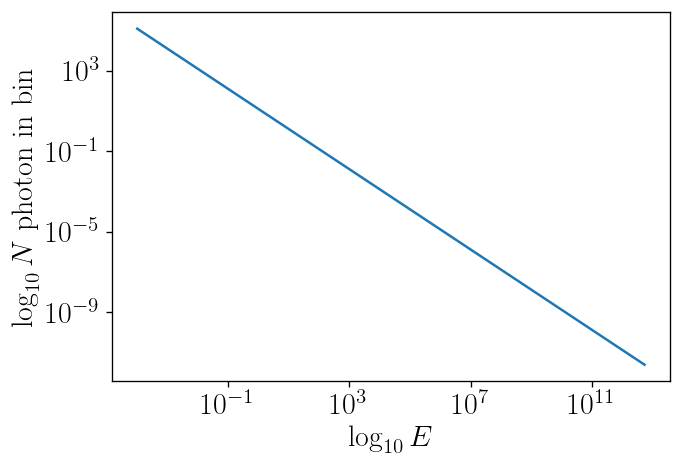

In [4]:
spec = Spectrum(abscs['photE'], np.ones_like(abscs['photE']), spec_type='N')
plt.plot(abscs['photE'], spec.dNdE)
plt.xlabel('$\log_{10} E$')
plt.ylabel('$\log_{10} N$ photon in bin')
plt.loglog();

## 2. Define and applying a TransferFunction

In [5]:
from dm21cm.transferfunction import TransferFunction

In [6]:
TransferFunction?

Init signature: TransferFunction(grid_vals, abscs, io_axes)
Docstring:     
Transfer function that maps Spectrum to Spectrum. (N -> N)

Parameters
----------
grid_vals : ndarray
    Grid values of transfer function. Row index: ingoing energy; column
    index: outgoing energy.
abscs : dict
    Dictionary of abscissa.
io_axes : list
    Names of input and output abscissa.


Attributes
----------
grid_vals : ndarray
abscs : dict
in_abscs : ndarray
out_abscs : ndarray
File:           /work/submit/yitians/DM21cm/dm21cm/transferfunction.py
Type:           type
Subclasses:     


In [7]:
# generate fake data
in_eng_ss, out_eng_ss = np.meshgrid(abscs['photE'], abscs['elecEk'])
data = np.sin(np.log(in_eng_ss)/2) * np.sin(np.log(out_eng_ss)/2)

tf = TransferFunction(data, abscs, ['photE', 'elecEk']) # N -> N type transfer function

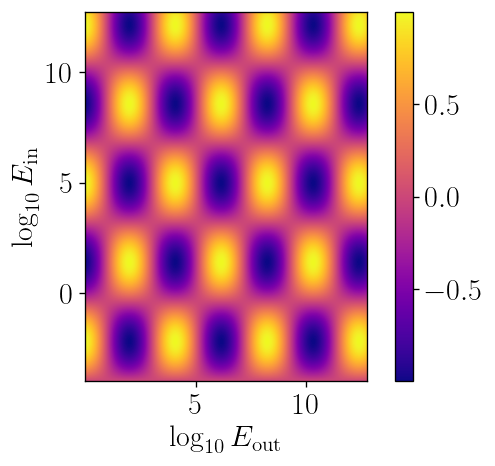

In [8]:
plt.imshow(np.flipud(tf.grid_vals), extent=np.log10(tf.extent), cmap='plasma')
plt.xlabel('$\log_{10} E_\mathrm{out}$')
plt.ylabel('$\log_{10} E_\mathrm{in}$')
plt.colorbar();

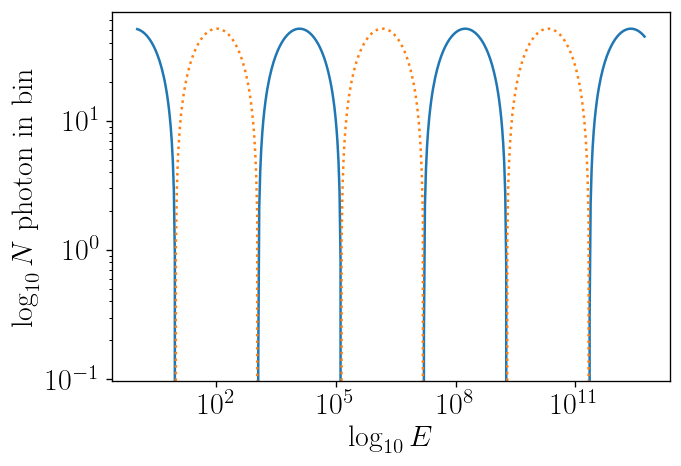

In [9]:
# applying transfer function to a spectrum
out_spec = tf(spec)

plt.plot(out_spec.eng, out_spec.N)
plt.plot(out_spec.eng, -out_spec.N, ':')
plt.xlabel('$\log_{10} E$')
plt.ylabel('$\log_{10} N$ photon in bin')
plt.loglog();

## 3. Get a TransferFunction or Depositions from a Interpolator

In [10]:
import pickle

In [11]:
phot_tf = pickle.load(open(os.environ['DM21CM_DATA_DIR']+'/transferfunctions/nBs_test/phot_tf.interp', 'rb'))

In [12]:
tf = phot_tf(nBs=1, x=0.5, rs=10)

In [13]:
EPSILON = 1e-100
def plot_val(x):
    return np.flipud(np.log10(np.clip(np.abs(x), EPSILON, None)))

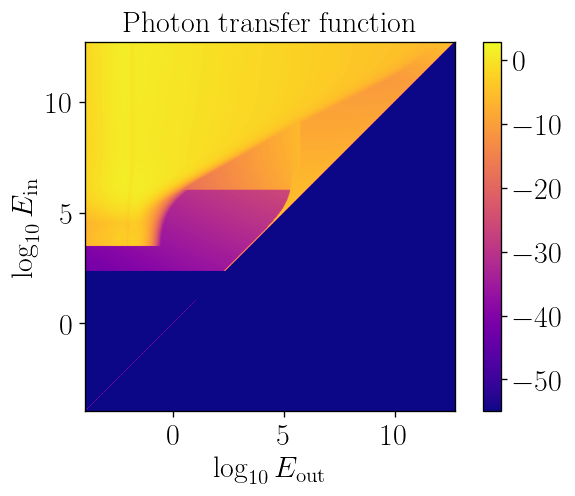

In [14]:
plt.imshow(plot_val(tf.grid_vals), extent=np.log10(tf.extent), cmap='plasma', vmin=-55)
plt.title('Photon transfer function')
plt.xlabel('$\log_{10} E_\mathrm{out}$')
plt.ylabel('$\log_{10} E_\mathrm{in}$')
plt.colorbar();

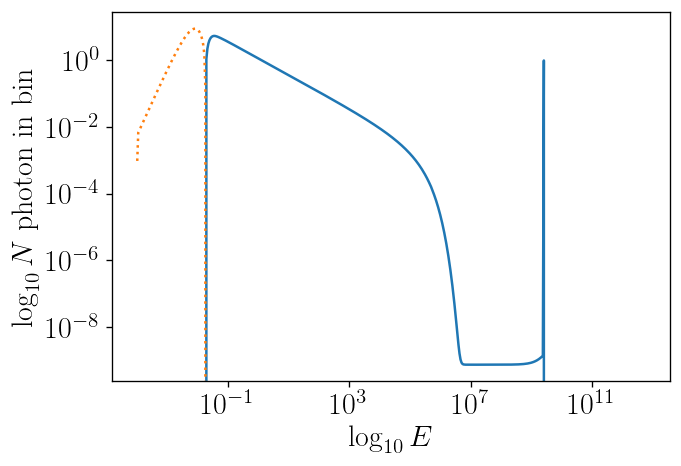

In [15]:
# applying transfer function to a spectrum
spec_data = np.zeros((500,))
spec_data[400] = 1
spec = Spectrum(abscs['photE'], spec_data, spec_type='N')
out_spec = phot_tf(nBs=0.7, x=0.3, rs=14)(spec)

plt.plot(out_spec.eng, out_spec.N)
plt.plot(out_spec.eng, -out_spec.N, ':')
plt.loglog()
plt.xlabel('$\log_{10} E$')
plt.ylabel('$\log_{10} N$ photon in bin');

## 4. Energy deposition $f$'s

In [17]:
phot_dep = pickle.load(open(os.environ['DM21CM_DATA_DIR']+'/transferfunctions/nBs_test/phot_dep.interp', 'rb'))

In [18]:
from dm21cm.transferfunction import Depositions

In [19]:
Depositions?

Init signature: Depositions(grid_vals, abscs, io_axes)
Docstring:     
Simple class for calculating energy deposition for injected photons.

Parameters
----------
grid_vals : ndarray
    Grid values of transfer function. Row index: ingoing energy; column
    index: channel.
abscs : dict
    Dictionary of abscissa.
io_axes : list
    Names of input and output abscissa.


Attributes
----------
grid_vals : ndarray
abscs : dict
in_abscs : ndarray
out_abscs : ndarray
File:           /work/submit/yitians/DM21cm/dm21cm/transferfunction.py
Type:           type
Subclasses:     


In [20]:
dep = phot_dep(nBs=1, x=0.5, rs=10)

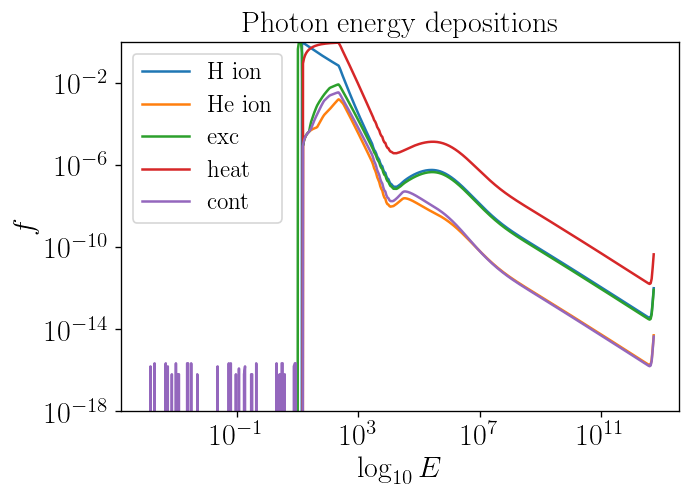

In [21]:
for gv, label in zip(np.transpose(dep.grid_vals), dep.out_abscs):
    plt.plot(dep.in_abscs, gv, label=label)
plt.loglog()
plt.ylim(1e-18, 1)
plt.title('Photon energy depositions')
plt.xlabel('$\log_{10} E$')
plt.ylabel('$f$')
plt.legend();

In [22]:
# applying deposition transfer function to a spectrum
dep(spec)

{'H ion': 3.281911159815411e-11,
 'He ion': 1.660165537613328e-13,
 'exc': 2.731479837248166e-11,
 'heat': 1.4780138074285655e-09,
 'cont': 1.5004639674672326e-13}